In [1]:
import os
from numpy import sqrt
from pyroot_module import *


Welcome to JupyROOT 6.15/01
Delphes classes imported


### Setting PATH and loading libraries for Delphes and ExRootAnalysis 

In [2]:
#path of folder to save the images
imgPath = './images/spin0/2020-06-18/'

### Reading trees and selecting branches

In [3]:
# getting signal and background trees
# signal
backgroundPath = './data/background/'
signalPath = '/home/santiago/VBF_DMSimp_spin0_EWKExcluded/Events/run_19/'

fs = [] #Signal files
imgFold = [] #Images forlders
for f in os.listdir(signalPath):
    if os.path.isfile(signalPath + f) and '.root' in f:
        fs.append(ROOT.TFile(signalPath + f))
    
        #create folder to save images
        imgFold.append((imgPath+f).replace('.root',''))
        if not os.path.exists(imgFold[-1]):
            os.makedirs(imgFold[-1])
    
        
#Signal trees
s = [f.Get("Delphes") for f in fs]

# background
b = ROOT.TChain("Delphes")
b.Add(backgroundPath + "santiago_run_02.root") #no
b.Add(backgroundPath + "santiago_run_05.root") #no
b.Add(backgroundPath + "santiago_run_07.root") #no

# number of signal and background events 
nb = int(b.GetEntries())
ns = [int(k.GetEntries()) for k in s]

# number of bins to book histograms
nbBins = int(sqrt(nb))+1
nsBins = [int(sqrt(n))+1 for n in ns] 

# reading trees and selecting branches
treeB = ROOT.ExRootTreeReader(b)
treeS = [ROOT.ExRootTreeReader(t) for t in s]

jetB = treeB.UseBranch("Jet")
jetS = [tree.UseBranch("Jet") for tree in treeS]

metB = treeB.UseBranch("MissingET")
metS = [tree.UseBranch("MissingET") for tree in treeS]

HtS = [tree.UseBranch("ScalarHT") for tree in treeS]
HtB = treeB.UseBranch("ScalarHT")

# number of jets to use
numJets = 5

ExRootAnalysisDict dictionary payload:16:10: fatal error: 'ExRootAnalysis/ExRootTreeReader.h' file not found
#include "ExRootAnalysis/ExRootTreeReader.h"
         ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Error in <TInterpreter::AutoParse>: Error parsing payload code for class ExRootTreeReader with content:

#line 1 "ExRootAnalysisDict dictionary payload"

#ifndef G__VECTOR_HAS_CLASS_ITERATOR
  #define G__VECTOR_HAS_CLASS_ITERATOR 1
#endif

#define _BACKWARD_BACKWARD_WARNING_H

/** \class ExRootAnalysisLinkDef
 *
 *  Lists classes to be included in cint dicitonary
 *
 *  \author P. Demin - UCL, Louvain-la-Neuve
 *
 */

#include "ExRootAnalysis/ExRootTreeReader.h"
#include "ExRootAnalysis/ExRootTreeWriter.h"
#include "ExRootAnalysis/ExRootTreeBranch.h"
#include "ExRootAnalysis/ExRootResult.h"
#include "ExRootAnalysis/ExRootUtilities.h"
#include "ExRootAnalysis/ExRootClassifier.h"
#include "ExRootAnalysis/ExRootFilter.h"

#include "ExRootAnalysis/ExRootProgressBar.h"
#include "ExRootAnalysis/E

### Book histograms

In [4]:
#---------------------------
#           signal
#---------------------------
hsDeltaEtaJet = [ROOT.TH1F("hsDeltaEtaJet_{0}".format(j), "Delta_Eta_Jet12_{0}".format(j), 50,0,10)
                for j in range(len(s))]

#Delta Eta for the two jets with highest invariant mass
hsDeltaEtaMaxIM = [ROOT.TH1F("hsDeltaEtaM_{0}".format(j), "Delta_Eta_M_{0}".format(j), 50,0,10) 
                   for j in range(len(s))]
hsMass = [ROOT.TH1F("hSMass_{0}".format(j), "M(j1,j2)_{0}".format(j), 65,0,4000)
         for j in range(len(s))]

# Highest invariant mass between to jets
hsMassMax = [ROOT.TH1F("hsMjj_{0}".format(j), "Max_M_{0}".format(j), 65,0,4000)
            for j in range(len(s))]

hsDeltaPhi = [ROOT.TH1F("hsDeltaPhi_{0}".format(j), "delta_Phi_{0}".format(j), 50, -1, 4)
              for j in range(len(s))]

# Delta phi for the two jets with highest invariant mass
hsDeltaPhiMax = [ROOT.TH1F("hsDeltaPhiMax_{0}".format(j), "Max_delta_phi_{0}".format(j), 50, -1, 4)
                 for j in range(len(s))]

hsDeltaPhiMetJet = [[ROOT.TH1F("hsDelPhiMet_j{0}_{1}".format(i,j),"dMetJ{0}_{1}".format(i,j), 50, -1, 4) 
                     for i in range(numJets)] 
                    for j in range(len(s))]

hsMetET = [ROOT.TH1F("hsMetET_{0}".format(j), "MET_ET_{0}".format(j), 50, 0.0, 2000)
           for j in range(len(s))]

hsHt = [ROOT.TH1F("hsHT_{0}".format(j),"HT_{0}".format(j),50,0,2000) for j in range(len(s))]

#---------------------------
#        background
#---------------------------
hbDeltaEtaJet = ROOT.TH1F("hbDeltaEtaJet", "Delta_Eta_Jet12", 50,0,10)
hbDeltaEtaMaxIM = ROOT.TH1F("hbDeltaEtaMaxIM", "Delta_Eta_MaxIM", 50,0,10)
hbMass = ROOT.TH1F("hbMass", "M(j1,j2)", 65,0,4000)
hbMassMax = ROOT.TH1F("hbMjj", "Max_M", 65,0,4000)
hbDeltaPhi = ROOT.TH1F("hbDeltaPhi", "delta_Phi", 50, -1, 4)
hbDeltaPhiMax = ROOT.TH1F("hbDeltaPhiMax", "Max_delta_phi", 50, -1, 4)
hbDeltaPhiMetJet = [ROOT.TH1F("hbDelPhiMet_j{0}".format(i),"dMetJ{0}".format(i), 50, -1, 4) 
                    for i in range(numJets)]
hbMetET = ROOT.TH1F("hbMetET", "MET_ET", 50, 0.0, 2000)
hbHt = ROOT.TH1F("hbHT","HT",50,0,2000)

### Creating dictionaries for the cuts

In [5]:
s_c = { 'cut0':0, 'cut1':0, 'cut2':0, 'cut3':0, 'cut4':0, 'cut5':0, 'cut6':0}
b_c = { 'cut0':0, 'cut1':0, 'cut2':0, 'cut3':0, 'cut4':0, 'cut5':0, 'cut6':0}
c_c = { 'cut0': r'$no\ cuts$',
        'cut1': r'$H_T$',        
        'cut2': r'$N^o Jets \geq 2$',
        'cut3': r'$P_T(J_i)>30\ i=0,1$',
        'cut4': r'$\eta (J_0)*\eta (J_1) < 0$',
        'cut5': r'$|\Delta \phi (J_0,J_1)| \geq 2.3$',
        'cut6': r'$max(m(J_i,J_j)) \geq 1000$'}

### Selecting events and filling histograms

In [6]:
# Loop over all signal events
for k in range(len(ns)):
    print(k)
    for event in range(ns[k]):
        #Load selected branches with data from specified event
        treeS[k].ReadEntry(event)

        # cuts
        s_c['cut0'] += 1
        
        if HtS[k].At(0).HT <= 200 : continue
        s_c['cut1'] += 1
        
        # select events with at least 2 jets
        if jetS[k].GetEntries() < 2: continue
        s_c['cut2'] += 1
        
        if jetS[k].At(0).PT <= 0 or jetS[k].At(1).PT <= 0: continue
        s_c['cut3'] += 1
        
        # select events with jets in opposite hemispheres 
        if (jetS[k].At(0).Eta * jetS[k].At(1).Eta) >= 0: continue
        s_c['cut4'] += 1
        
        if abs(DeltaPhi(jetS[k].At(0).Phi,jetS[k].At(1).Phi)) < 2.3: continue
        s_c['cut5'] += 1
            
        i = 0
        j = 0
        JsMass = 0
        NJets = jetS[k].GetEntries() if jetS[k].GetEntries() <= numJets else numJets
        dPhiMetJet = []
        for n in range(NJets):
            # selecting the two jet system 
            # with the largest invariant mass
            dPhiMetJet.append(abs(DeltaPhi(metS[k].At(0).Phi,jetS[k].At(n).Phi)))            
            for m in range(NJets):
                if n==m:continue
                a = InvariantMass(jetS[k],n,m) 
                if a > JsMass:
                    i,j = m,n
                    JsMass = a
                              
        # Cut for maximum invariant mass
        if JsMass < 1000 : continue
        s_c['cut6'] += 1
                              
        for n in range(NJets):
            hsDeltaPhiMetJet[k][n].Fill(dPhiMetJet[n])                              
        hsDeltaEtaJet[k].Fill(abs(jetS[k].At(0).Eta-jetS[k].At(1).Eta))
        hsDeltaEtaMaxIM[k].Fill(abs(jetS[k].At(i).Eta-jetS[k].At(j).Eta))
        hsMass[k].Fill(InvariantMass(jetS[k],0,1))
        hsMassMax[k].Fill(JsMass)
        hsDeltaPhi[k].Fill(abs(DeltaPhi(jetS[k].At(0).Phi,jetS[k].At(1).Phi)))
        hsDeltaPhiMax[k].Fill(abs(DeltaPhi(jetS[k].At(i).Phi,jetS[k].At(j).Phi)))
        hsMetET[k].Fill(metS[k].At(0).MET)
        hsHt[k].Fill(HtS[k].At(0).HT)

0


In file included from ClassesDict dictionary payload:34:
/home/santiago/MG5_aMC_v2_6_5/Delphes/classes/DelphesModule.h:30:10: fatal error: 'ExRootAnalysis/ExRootTask.h' file not found
#include "ExRootAnalysis/ExRootTask.h"
         ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Error in <TInterpreter::AutoParse>: Error parsing payload code for class ScalarHT with content:

#line 1 "ClassesDict dictionary payload"

#ifndef G__VECTOR_HAS_CLASS_ITERATOR
  #define G__VECTOR_HAS_CLASS_ITERATOR 1
#endif

#define _BACKWARD_BACKWARD_WARNING_H
/*
 *  Delphes: a framework for fast simulation of a generic collider experiment
 *  Copyright (C) 2012-2014  Universite catholique de Louvain (UCL), Belgium
 *
 *  This program is free software: you can redistribute it and/or modify
 *  it under the terms of the GNU General Public License as published by
 *  the Free Software Foundation, either version 3 of the License, or
 *  (at your option) any later version.
 *
 *  This program is distributed in the hope that it will

In [7]:
# Loop over all background events 
for event in range(nb):
    # load selected branches with data from specified event
    treeB.ReadEntry(event)
    
    # cuts
    b_c['cut0'] += 1
    
    if HtB.At(0).HT <= 200: continue
    b_c['cut1'] += 1
    
    # select events with at least 2 jets
    if jetB.GetEntries() < 2: continue
    b_c['cut2'] += 1
    
    if jetB.At(0).PT < 30 or jetB.At(1).PT < 30 : continue
    b_c['cut3'] += 1
    
    # select events with jets in opposite hemispheres 
    if (jetB.At(0).Eta * jetB.At(1).Eta) >= 0: continue
    b_c['cut4'] += 1
    
    if abs(DeltaPhi(jetB.At(0).Phi,jetB.At(1).Phi)) < 2.3: continue
    b_c['cut5'] += 1
        
    i = 0
    j = 0
    JbMass = 0
    NJets = jetB.GetEntries() if jetB.GetEntries() <= numJets else numJets
    dPhiMetJet = []
    for n in range(NJets):
        # selecting the two jet system 
        # with the largest invariant mass
        dPhiMetJet.append(abs(DeltaPhi(metB.At(0).Phi,jetB.At(n).Phi)))
        for m in range(NJets):
            if n==m:continue
            a = InvariantMass(jetB,n,m) 
            if a > JbMass:
                i,j = m,n
                JbMass = a

   # Cut for maximum invariant mass
    if JbMass < 1000 : continue
    b_c['cut6'] += 1
                
    for n in range(NJets):         
        hbDeltaPhiMetJet[n].Fill(dPhiMetJet[n])        
    hbDeltaEtaJet.Fill(abs(jetB.At(0).Eta-jetB.At(1).Eta))
    hbDeltaEtaMaxIM.Fill((abs(jetB.At(i).Eta-jetB.At(j).Eta)))
    hbMass.Fill(InvariantMass(jetB,0,1))
    hbMassMax.Fill(JbMass)
    hbDeltaPhi.Fill(abs(DeltaPhi(jetB.At(0).Phi,jetB.At(1).Phi)))
    hbDeltaPhiMax.Fill(abs(DeltaPhi(jetB.At(i).Phi,jetB.At(j).Phi)))
    hbMetET.Fill(metB.At(0).MET)
    hbHt.Fill(HtB.At(0).HT)

## Cut flow

In [8]:
f1,f2 = CutFlow(s_c,b_c,c_c,7,ns[0],nb)
print('ns = {}'.format(ns[0]))
print('nb = {}'.format(nb))

ns = 50000
nb = 146922


In [9]:
f1

,${\textbf{[bold]: GeV}}$,S,B,Z
cut0,$no\ cuts$,50000.0,146922.0,234.415327
cut1,$H_T$,49969.0,113296.0,260.687952
cut2,$N^o Jets \geq 2$,49969.0,106884.0,266.816071
cut3,"$P_T(J_i)>30\ i=0,1$",49969.0,100952.0,272.888075
cut4,$\eta (J_0)*\eta (J_1) < 0$,22843.0,43325.0,189.095050
cut5,"$|\Delta \phi (J_0,J_1)| \geq 2.3$",20611.0,11999.0,263.511861
cut6,"$max(m(J_i,J_j)) \geq 1000$",16519.0,2778.0,295.556076


In [10]:
f2

,${\textbf{[bold]: GeV}}$,s_c,s_r,b_a,b_r
cut0,$no\ cuts$,1,1,1,1
cut1,$H_T$,0.99938,0.99938,0.77113,0.77113
cut2,$N^o Jets \geq 2$,0.99938,1,0.727488,0.943405
cut3,"$P_T(J_i)>30\ i=0,1$",0.99938,1,0.687113,0.944501
cut4,$\eta (J_0)*\eta (J_1) < 0$,0.45686,0.457143,0.294884,0.429164
cut5,"$|\Delta \phi (J_0,J_1)| \geq 2.3$",0.41222,0.90229,0.0816692,0.276953
cut6,"$max(m(J_i,J_j)) \geq 1000$",0.33038,0.801465,0.018908,0.231519


## Delta_Eta

Info in <TCanvas::Print>: png file ./images/spin0/2020-06-18/DMSimpSpin0_MY1000_MX100_14052020/hsDeltaEtaJet_0.png has been created
Info in <TCanvas::Print>: png file ./images/spin0/2020-06-18/DMSimpSpin0_MY1000_MX100_14052020/hbDeltaEtaJetsignificance.png has been created


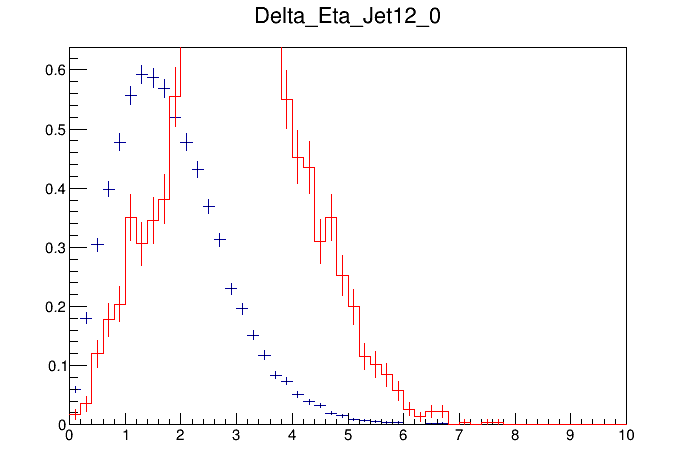

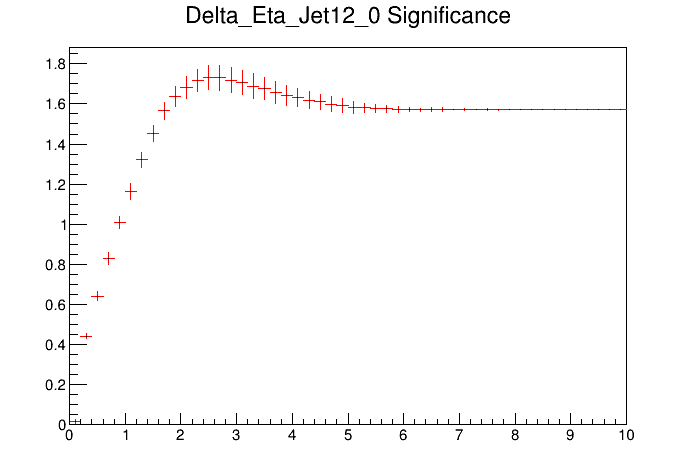

In [11]:
fList = open(imgPath + "fileList.txt","w+")
k=0
for f in os.listdir(signalPath):
    if os.path.isfile(signalPath + f) and '.root' in f:
        fList.write('%d\t%s\r\n'%(k,f))
        k+=1
fList.close()

for k in range(len(hsDeltaEtaJet)):
    HzsDEta = hsDeltaEtaJet[k].Clone()
    HzbDEta = hbDeltaEtaJet.Clone()
#     Histos(HzsDEta,HzbDEta, imgFold[k] + '/deltaEta_j12.png')
    PlotHistos(HzsDEta,HzbDEta,save=True,savePath=imgFold[k])
#     Hz = Sig(HzsDEta, HzbDEta, ns=ns[k], nb=nb)
#     Histo(Hz,imgFold[k] + '/z_DeltaEta_j1_j2.png')
    Hz = Significance(HzsDEta, HzbDEta, ns=ns[k], nb=nb, lessThan=True)
    PlotHisto(Hz,save=True,savePath=imgFold[k])

### Delta Eta maximum invariant mass jet

Info in <TCanvas::Print>: png file ./images/spin0/2020-06-18/DMSimpSpin0_MY1000_MX100_14052020/hsDeltaEtaM_0.png has been created
Info in <TCanvas::Print>: png file ./images/spin0/2020-06-18/DMSimpSpin0_MY1000_MX100_14052020/hbDeltaEtaMaxIMsignificance.png has been created


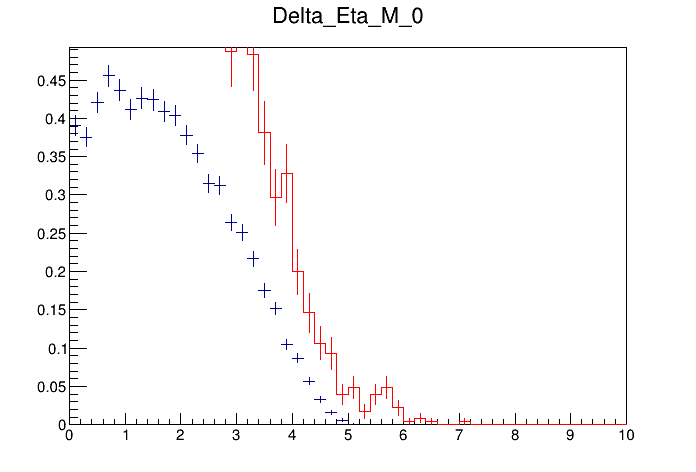

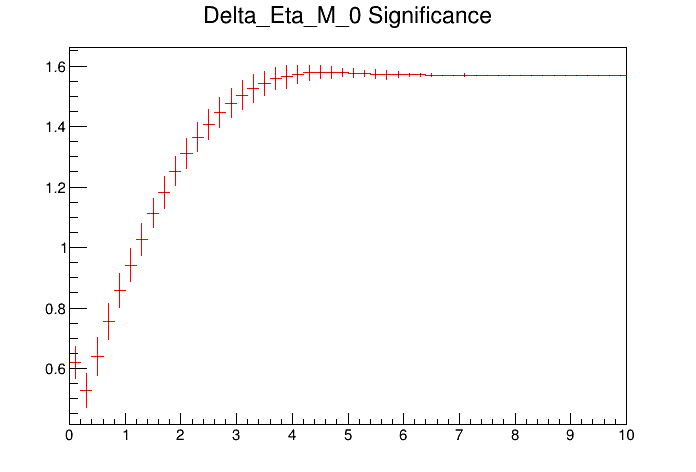

In [12]:
for k in range(len(hsDeltaEtaJet)):
    HzsMass = hsDeltaEtaMaxIM[k].Clone()
    HzbMass = hbDeltaEtaMaxIM.Clone()
#     Histos(HzsMass,HzbMass, imgFold[k] + '/deltaEta_MaxIM.png')
#     Hz = Sig(HzsMass, HzbMass, ns=ns[k], nb=nb)
#     Histo(Hz,imgFold[k] + '/z_DeltaEta_maxMassInv.png')
    PlotHistos(HzsMass,HzbMass,save=True,savePath=imgFold[k])
    Hz = Significance(HzsMass, HzbMass, ns=ns[k], nb=nb, lessThan=True)
    PlotHisto(Hz,save=True,savePath=imgFold[k])

## Invariant Mass

Info in <TCanvas::Print>: png file ./images/spin0/2020-06-18/DMSimpSpin0_MY1000_MX100_14052020/hSMass_0.png has been created
Info in <TCanvas::Print>: png file ./images/spin0/2020-06-18/DMSimpSpin0_MY1000_MX100_14052020/hbMasssignificance.png has been created


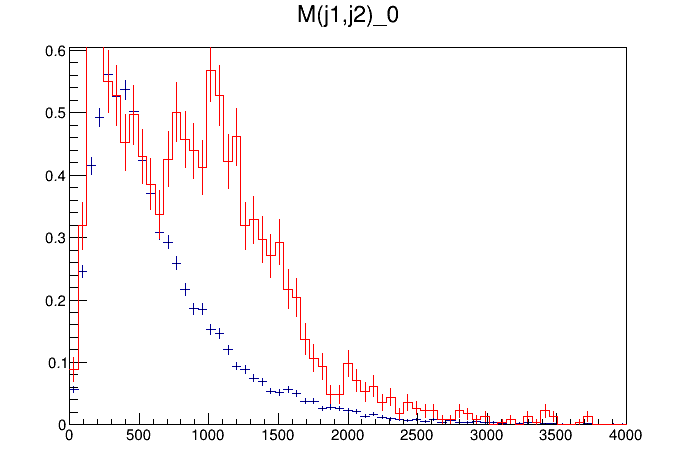

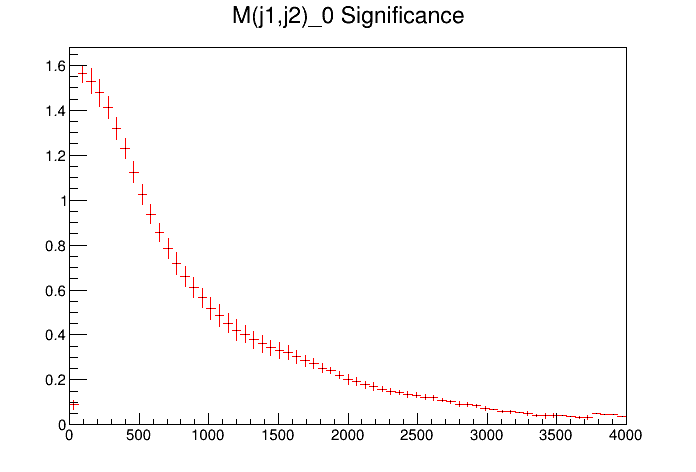

In [13]:
for k in range(len(hsDeltaEtaJet)):
    HsMass = hsMass[k].Clone()
    HbMass = hbMass.Clone()
#     Histos(HsMass,HbMass, imgFold[k] + '/m_j1_j2.png')
#     HzM = Sig(HsMass, HbMass, ns=ns[k], nb=nb)
#     Histo(HzM,imgFold[k] + '/z_m_j1_j2.png')
    PlotHistos(HsMass,HbMass, save=True,savePath=imgFold[k])
    HzM = Significance(HsMass, HbMass, ns=ns[k], nb=nb)
    PlotHisto(HzM,save=True,savePath=imgFold[k])

### Maximum invariant mass

Info in <TCanvas::Print>: png file ./images/spin0/2020-06-18/DMSimpSpin0_MY1000_MX100_14052020/hsMjj_0.png has been created
Info in <TCanvas::Print>: png file ./images/spin0/2020-06-18/DMSimpSpin0_MY1000_MX100_14052020/hbMjjsignificance.png has been created


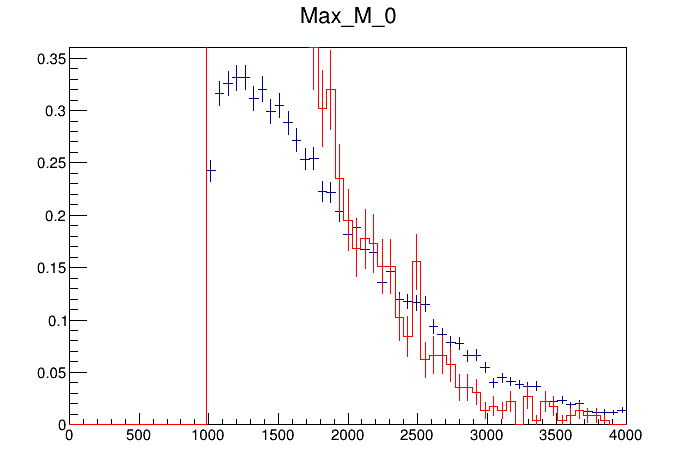

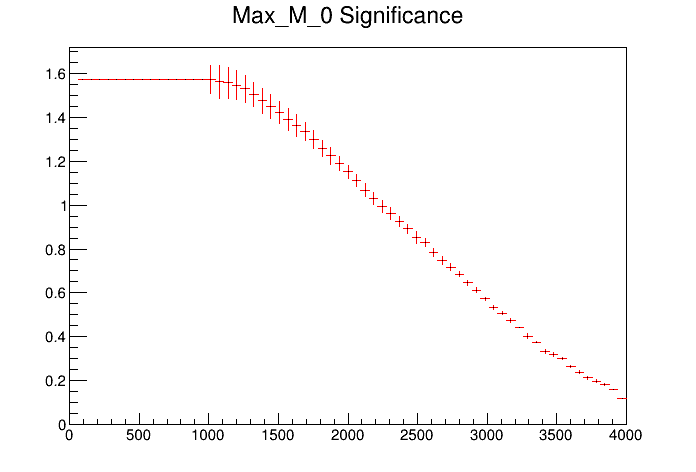

In [14]:
for k in range(len(hsDeltaEtaJet)):
    HsMass = hsMassMax[k].Clone()
    HbMass = hbMassMax.Clone()
#     Histos(HsMass,HbMass, imgFold[k] + '/m_max.png')
#     HzM = Sig(HsMass, HbMass, ns=ns[k], nb=nb)
#     Histo(HzM,imgFold[k] + '/z_m_maxMassInv.png')
    PlotHistos(HsMass,HbMass,save=True,savePath=imgFold[k])
    HzM = Significance(HsMass, HbMass, ns=ns[k], nb=nb)
    PlotHisto(HzM,save=True,savePath=imgFold[k])

### Delta Phi

Info in <TCanvas::Print>: png file ./images/spin0/2020-06-18/DMSimpSpin0_MY1000_MX100_14052020/hsDeltaPhi_0.png has been created
Info in <TCanvas::Print>: png file ./images/spin0/2020-06-18/DMSimpSpin0_MY1000_MX100_14052020/hbDeltaPhisignificance.png has been created


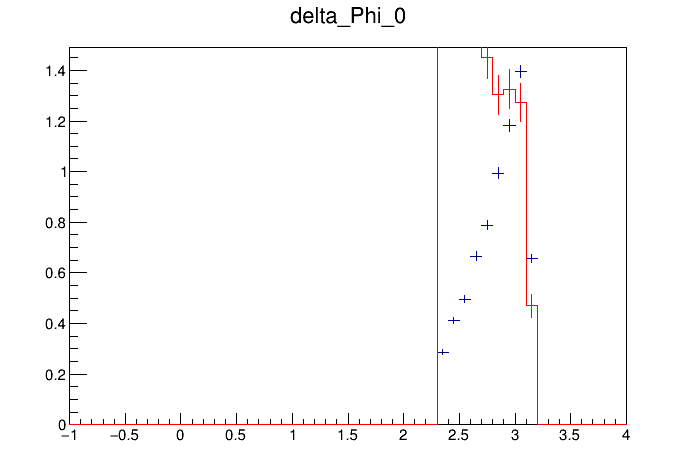

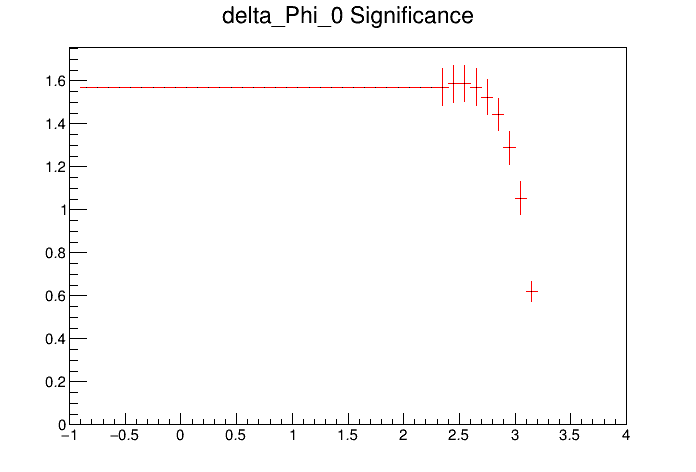

In [15]:
for k in range(len(hsDeltaEtaJet)):
    HzsPhi = hsDeltaPhi[k].Clone()
    HzbPhi = hbDeltaPhi.Clone()
#     Histos(HzsPhi,HzbPhi, imgFold[k] + '/deltaPhi(j1,j2).png')
    PlotHistos(HzsPhi,HzbPhi, save=True,savePath=imgFold[k])
    Hz = Significance(HzsPhi, HzbPhi, ns=ns[k], nb=nb)
    PlotHisto(Hz,save=True,savePath=imgFold[k])

### Delta Phi maximum invariant mass for two jets

Info in <TCanvas::Print>: png file ./images/spin0/2020-06-18/DMSimpSpin0_MY1000_MX100_14052020/hsDeltaPhiMax_0.png has been created
Info in <TCanvas::Print>: png file ./images/spin0/2020-06-18/DMSimpSpin0_MY1000_MX100_14052020/hbDeltaPhiMaxsignificance.png has been created


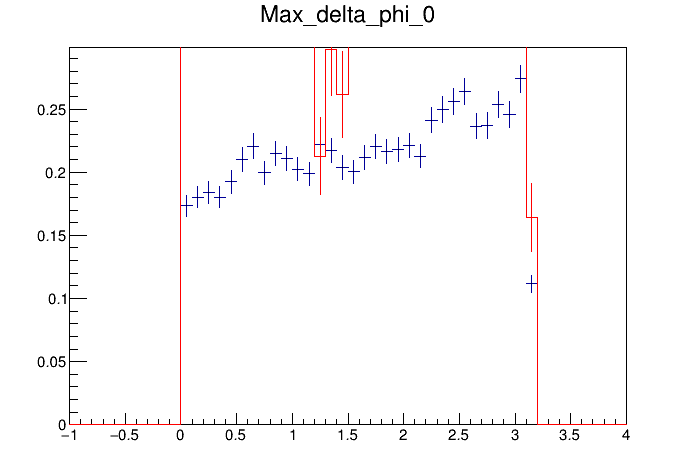

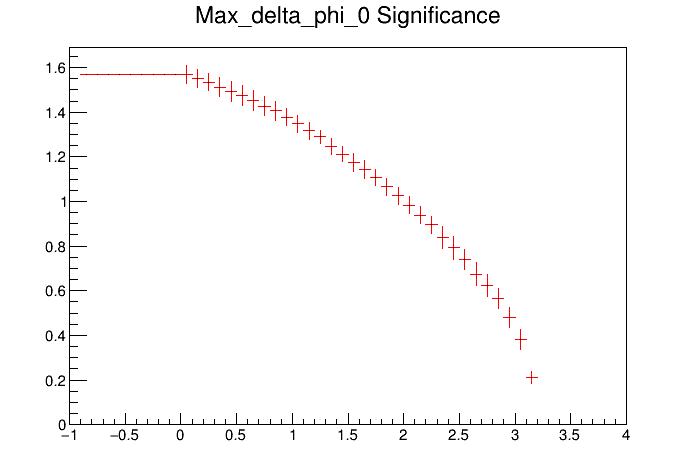

In [16]:
for k in range(len(hsDeltaEtaJet)):
    HzsPhi = hsDeltaPhiMax[k].Clone()
    HzbPhi = hbDeltaPhiMax.Clone()
#     Histos(HzsPhi,HzbPhi, imgFold[k] + '/deltaPhi__max.png')
    PlotHistos(HzsPhi,HzbPhi, save=True,savePath=imgFold[k])
    
    Hz = Significance(HzsPhi, HzbPhi, ns=ns[k], nb=nb)
    PlotHisto(Hz,save=True,savePath=imgFold[k])

### DeltaPhi(Met,Jet)

Info in <TCanvas::Print>: png file ./images/spin0/2020-06-18/DMSimpSpin0_MY1000_MX100_14052020/hsDelPhiMet_j0_0.png has been created
Info in <TCanvas::Print>: png file ./images/spin0/2020-06-18/DMSimpSpin0_MY1000_MX100_14052020/hbDelPhiMet_j0significance.png has been created
Info in <TCanvas::Print>: png file ./images/spin0/2020-06-18/DMSimpSpin0_MY1000_MX100_14052020/hsDelPhiMet_j1_0.png has been created
Info in <TCanvas::Print>: png file ./images/spin0/2020-06-18/DMSimpSpin0_MY1000_MX100_14052020/hbDelPhiMet_j1significance.png has been created
Info in <TCanvas::Print>: png file ./images/spin0/2020-06-18/DMSimpSpin0_MY1000_MX100_14052020/hsDelPhiMet_j2_0.png has been created
Info in <TCanvas::Print>: png file ./images/spin0/2020-06-18/DMSimpSpin0_MY1000_MX100_14052020/hbDelPhiMet_j2significance.png has been created
Info in <TCanvas::Print>: png file ./images/spin0/2020-06-18/DMSimpSpin0_MY1000_MX100_14052020/hsDelPhiMet_j3_0.png has been created
Info in <TCanvas::Print>: png file ./im

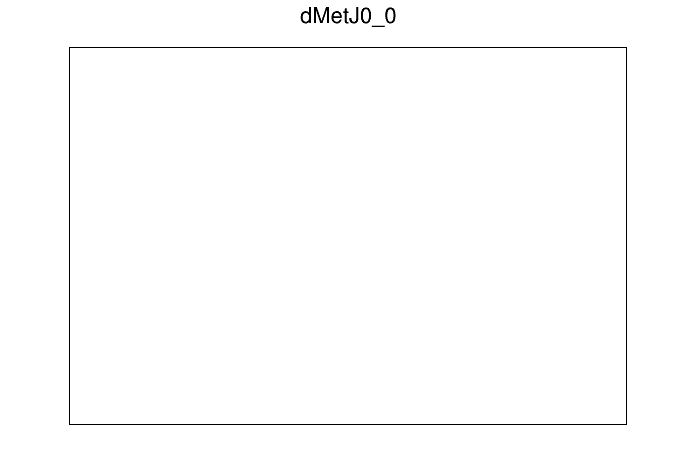

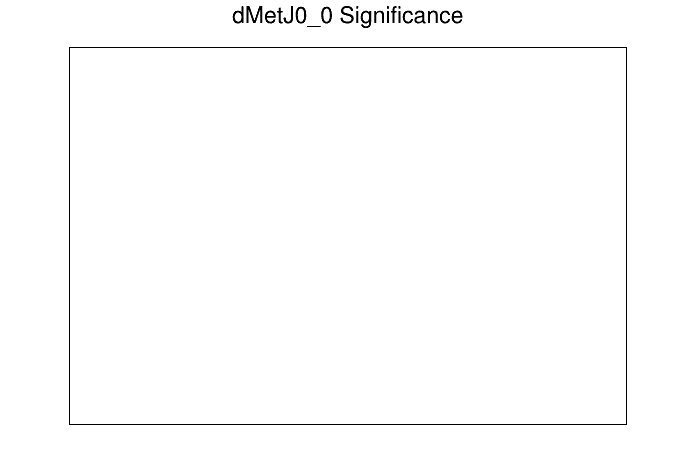

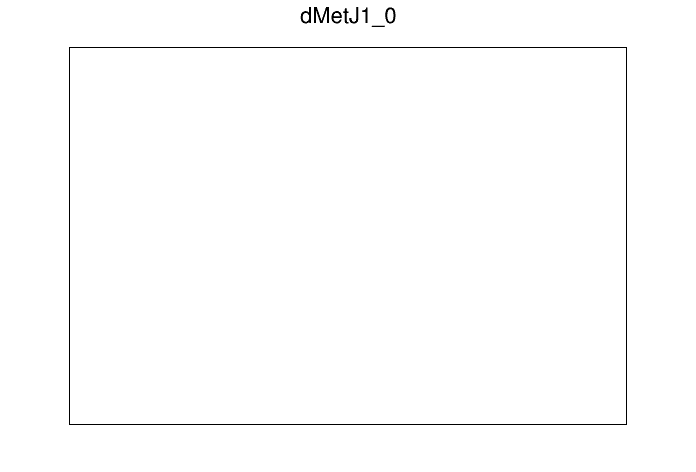

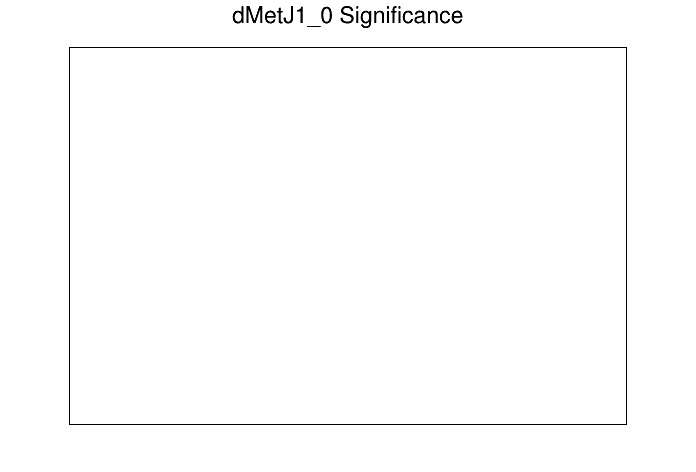

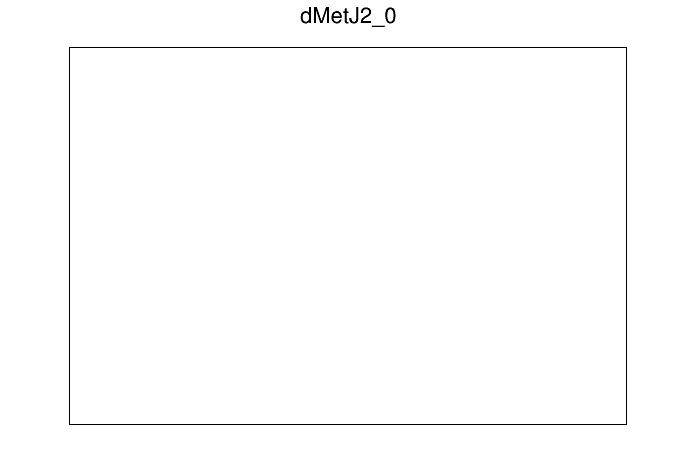

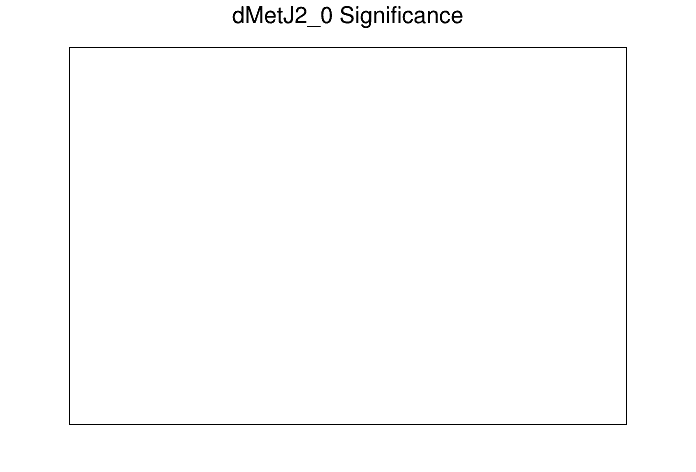

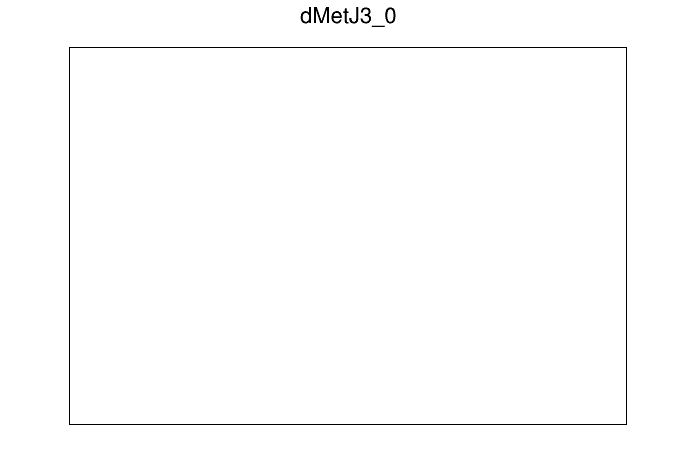

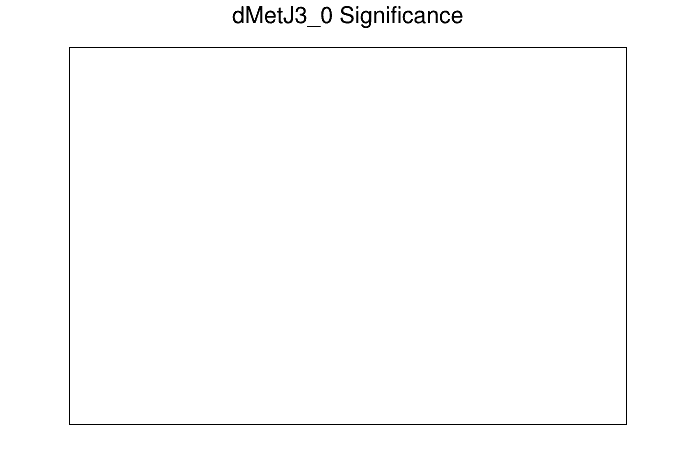

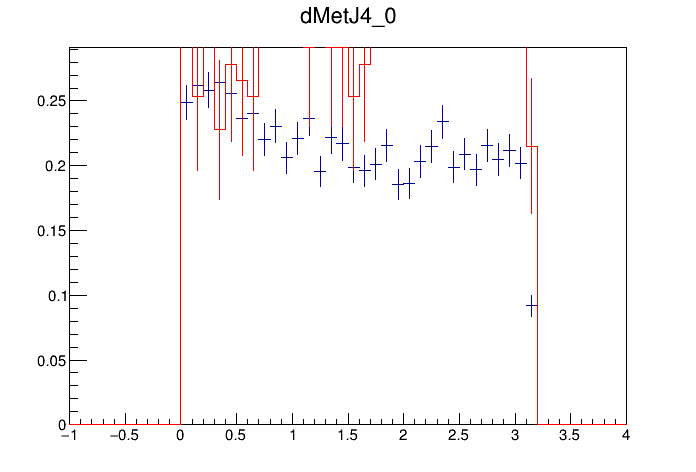

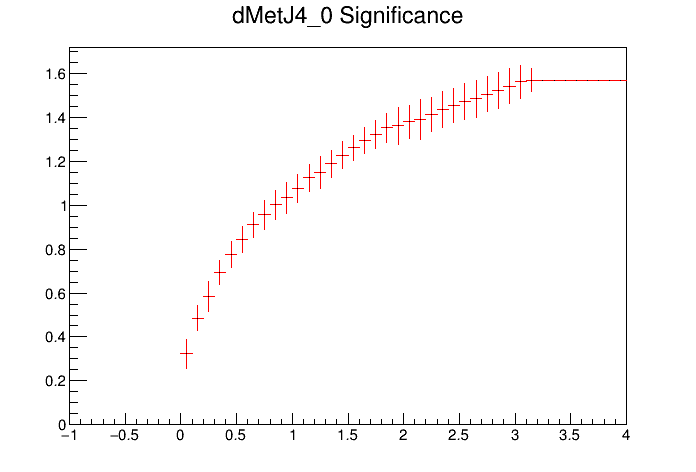

In [17]:
for k in range(len(hsDeltaEtaJet)):
    for n in range(numJets):
        HzsPhi = hsDeltaPhiMetJet[k][n].Clone()
        HzbPhi = hbDeltaPhiMetJet[n].Clone()
        PlotHistos(HzsPhi,HzbPhi, save=True,savePath=imgFold[k])
    
        Hz = Significance(HzsPhi, HzbPhi, ns=ns[k], nb=nb,lessThan=True)
        PlotHisto(Hz,save=True,savePath=imgFold[k])

### MET


Info in <TCanvas::Print>: png file ./images/spin0/2020-06-18/DMSimpSpin0_MY1000_MX100_14052020/hsMetET_0.png has been created
Info in <TCanvas::Print>: png file ./images/spin0/2020-06-18/DMSimpSpin0_MY1000_MX100_14052020/hbMetETsignificance.png has been created


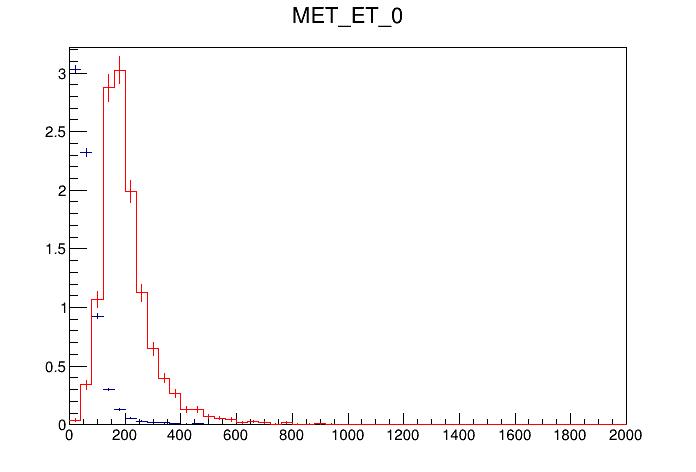

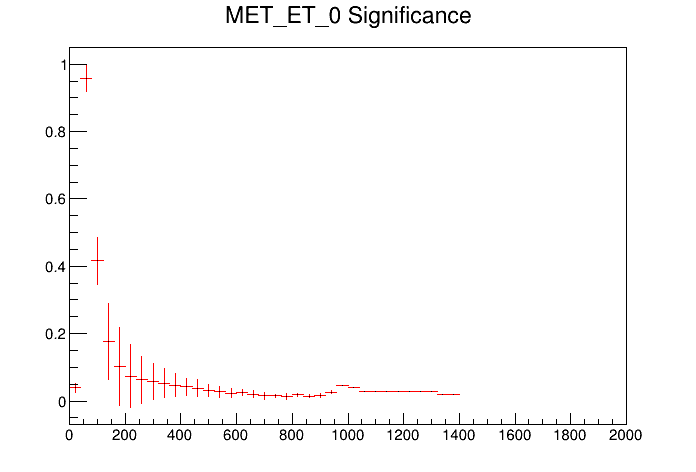

In [18]:
for k in range(len(hsDeltaEtaJet)):
    Hzs = hsMetET[k].Clone()
    Hzb = hbMetET.Clone()
#     Histos(HzsPhi,HzbPhi, imgFold[k] + '/deltaPhi__max.png')
    PlotHistos(Hzs,Hzb, save=True,savePath=imgFold[k])
    Hz = Significance(Hzs, Hzb, ns=ns[k], nb=nb)
    PlotHisto(Hz,save=True,savePath=imgFold[k])

### HT

Info in <TCanvas::Print>: png file ./images/spin0/2020-06-18/DMSimpSpin0_MY1000_MX100_14052020/hsHT_0.png has been created
Info in <TCanvas::Print>: png file ./images/spin0/2020-06-18/DMSimpSpin0_MY1000_MX100_14052020/hbHTsignificance.png has been created


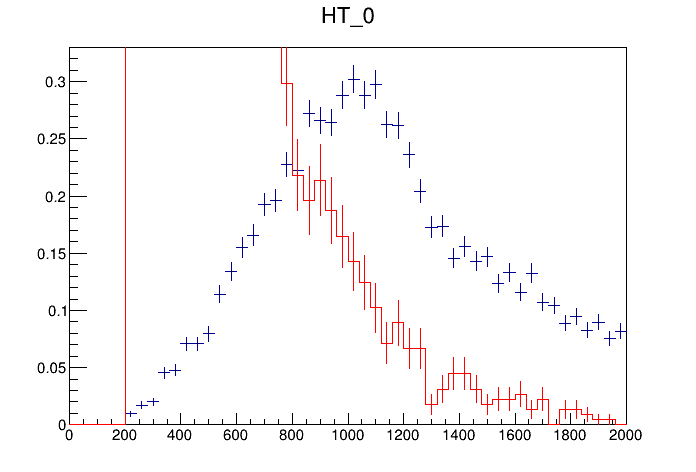

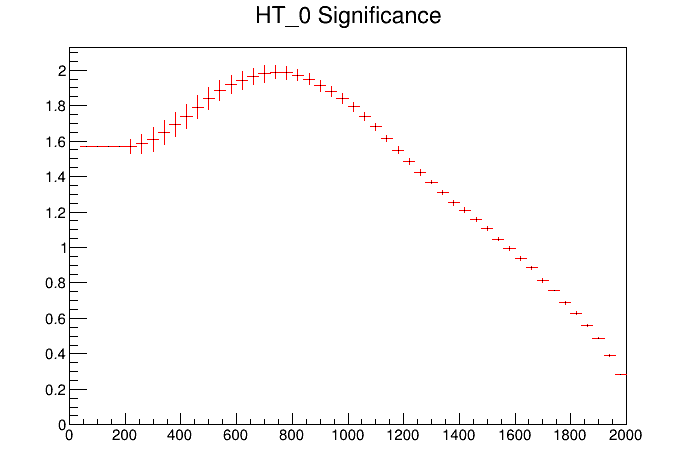

In [19]:
for k in range(len(hsDeltaEtaJet)):
    Hzs = hsHt[k].Clone()
    Hzb = hbHt.Clone()
#     Histos(HzsPhi,HzbPhi, imgFold[k] + '/deltaPhi__max.png')
    PlotHistos(Hzs,Hzb, save=True,savePath=imgFold[k])
    Hz = Significance(Hzs, Hzb, ns=ns[k], nb=nb)
    PlotHisto(Hz,save=True,savePath=imgFold[k])

In [20]:
jetB.At(0).PT < 30 or jetB.At(1) < 30 

True